In [1]:
import torch
import torchvision.transforms as transforms

import sys
sys.path.append('/home/oscar/catkin_ws/src/thesis/model/ggcnn')

### Import the model and see if it works

In [53]:
model = torch.load('ggcnn/ggcnn_weights_cornell/ggcnn_epoch_23_cornell', map_location=torch.device('cpu'))

model

/home/oscar/.local/lib/python3.11/site-packages/torch/serialization.py:888: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/oscar/.local/lib/python3.11/site-packages/torch/serialization.py:888: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


GGCNN(
  (conv1): Conv2d(1, 32, kernel_size=(9, 9), stride=(3, 3), padding=(3, 3))
  (conv2): Conv2d(32, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv3): Conv2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (convt1): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (convt2): ConvTranspose2d(8, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
  (convt3): ConvTranspose2d(16, 32, kernel_size=(9, 9), stride=(3, 3), padding=(3, 3), output_padding=(1, 1))
  (pos_output): Conv2d(32, 1, kernel_size=(2, 2), stride=(1, 1))
  (cos_output): Conv2d(32, 1, kernel_size=(2, 2), stride=(1, 1))
  (sin_output): Conv2d(32, 1, kernel_size=(2, 2), stride=(1, 1))
  (width_output): Conv2d(32, 1, kernel_size=(2, 2), stride=(1, 1))
)

### Image processing

In [66]:
import cv2
import numpy as np
from imageio.v2 import imread
from matplotlib import pyplot as plt
import scipy.ndimage as ndimage

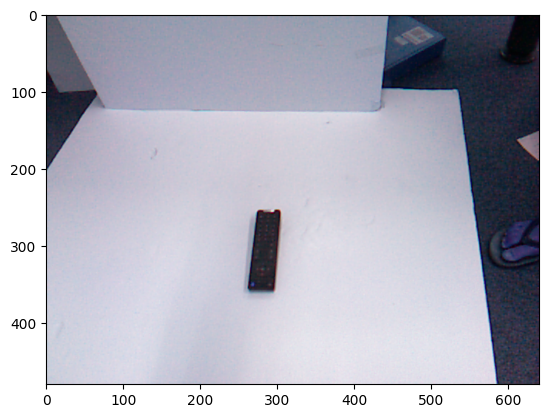

In [208]:
rgb = cv2.imread("rgb.png")
rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)

plt.imshow(rgb)
rgb = cv2.resize(rgb, (300, 300))
plt.show()

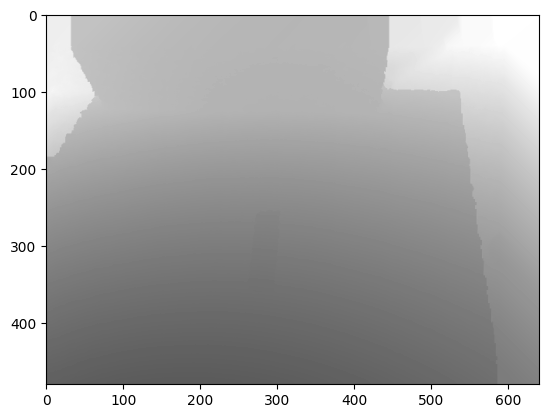

In [198]:
depth=imread('d.tiff')
plt.imshow(depth, cmap='gray')
plt.show()

In [199]:
# Crop a square out of the middle of the depth and resize it to 300*300
crop_size = 400
depth_crop = cv2.resize(depth[(480-crop_size)//2:(480-crop_size)//2+crop_size, (640-crop_size)//2:(640-crop_size)//2+crop_size], (300, 300))

# Replace nan with 0 for inpainting.
depth_crop = depth_crop.copy()
depth_nan = np.isnan(depth_crop).copy()
depth_crop[depth_nan] = 0

# open cv inpainting does weird things at the border.
depth_crop = cv2.copyMakeBorder(depth_crop, 1, 1, 1, 1, cv2.BORDER_DEFAULT)

mask = (depth_crop == 0).astype(np.uint8)

# Scale to keep as float, but has to be in bounds -1:1 to keep opencv happy.
depth_scale = np.abs(depth_crop).max()
depth_crop = depth_crop.astype(np.float32)/depth_scale  # Has to be float32, 64 not supported.

depth_crop = cv2.inpaint(depth_crop, mask, 1, cv2.INPAINT_NS)

# Back to original size and value range.
depth_crop = depth_crop[1:-1, 1:-1]
depth_crop = depth_crop * depth_scale

# Run it through the network.
depth_crop = np.clip((depth_crop - depth_crop.mean()), -1, 1)

depth_crop = depth_crop.reshape((1, 300, 300))

depth_crop = torch.from_numpy(depth_crop.astype(np.float32))

In [200]:
with torch.no_grad():
    pred_out = model.forward(depth_crop)
    points_out = pred_out[0].squeeze()
    points_out[depth_nan] = 0
    
# Calculate the angle map.
cos_out = pred_out[1].squeeze()
sin_out = pred_out[2].squeeze()
ang_out = np.arctan2(sin_out, cos_out)/2.0

width_out = pred_out[3].squeeze() * 150.0  # Scaled 0-150:0-1   

# Filter the outputs.
points_out = ndimage.gaussian_filter(points_out, 5.0)  # 3.0
ang_out = ndimage.gaussian_filter(ang_out, 2.0)

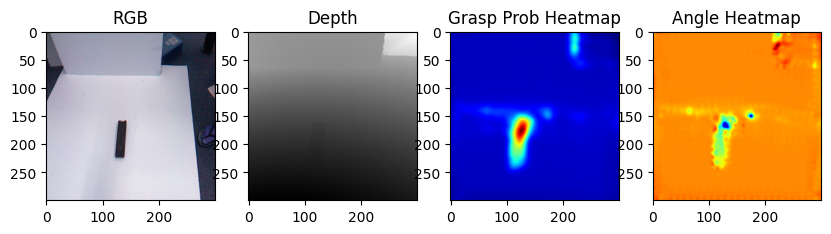

In [201]:
fig, axes = plt.subplots(ncols=4, figsize=(10, 5))

axes[0].imshow(cv2.resize(rgb, (300, 300)))
axes[0].set_title('RGB')

axes[1].imshow(depth_crop.squeeze(), cmap='gray')
axes[1].set_title('Depth')

axes[2].imshow(points_out, cmap='jet')
axes[2].set_title('Grasp Prob Heatmap')

axes[3].imshow(ang_out, cmap='jet')
axes[3].set_title('Angle Heatmap')

plt.show()

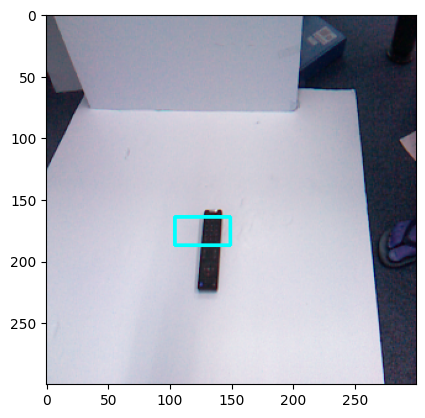

In [207]:
max_pixel = np.unravel_index(max_index, points_out.shape)
ang = ang_out[max_pixel[0], max_pixel[1]]
ang = ang_out.max()

width = width_out[max_pixel[0], max_pixel[1]]

center = (int(max_pixel[0]), int(max_pixel[1]))

# Define the coordinates of the square
w, h = width, width/2
x, y = center[1] - w/2, center[0] - h/2

points = [(x, y), (x+w, y), (x+w, y+h), (x, y+h)]

M = cv2.getRotationMatrix2D(center, ang, 1)

# Rotate the square
rotated_points = [tuple(M.dot((p[0], p[1], 1))[:2]) for p in points]

# Draw the rotated square onto the image
pts = np.array(rotated_points, np.int32)
pts = pts.reshape((-1,1,2))
cv2.polylines(rgb,[pts],True,(0,255,255),2)

plt.imshow(rgb)
plt.show()